# **The Optimal BERT Surgeon: Scalable and Accurate Second-Order Pruning for Large Language Models (oBERT)**

Paper: https://arxiv.org/abs/2203.07259

The oBERT implementation is integrated with the SparseML library in the form of OBSPruningModifier, making it very easy to run experiments with, reproduce results from the paper or even compress new models. We also provide bash scripts and recipes used to produce results from the paper, and they can be easily modified to encompass new models and datasets.

Here, we extract the algoritmic part for oBERT unstructured pruning from the OBSPruningModifier to showcase the main operations involved in the pruning process.

In [ ]:
import math
import torch
from torch import Tensor

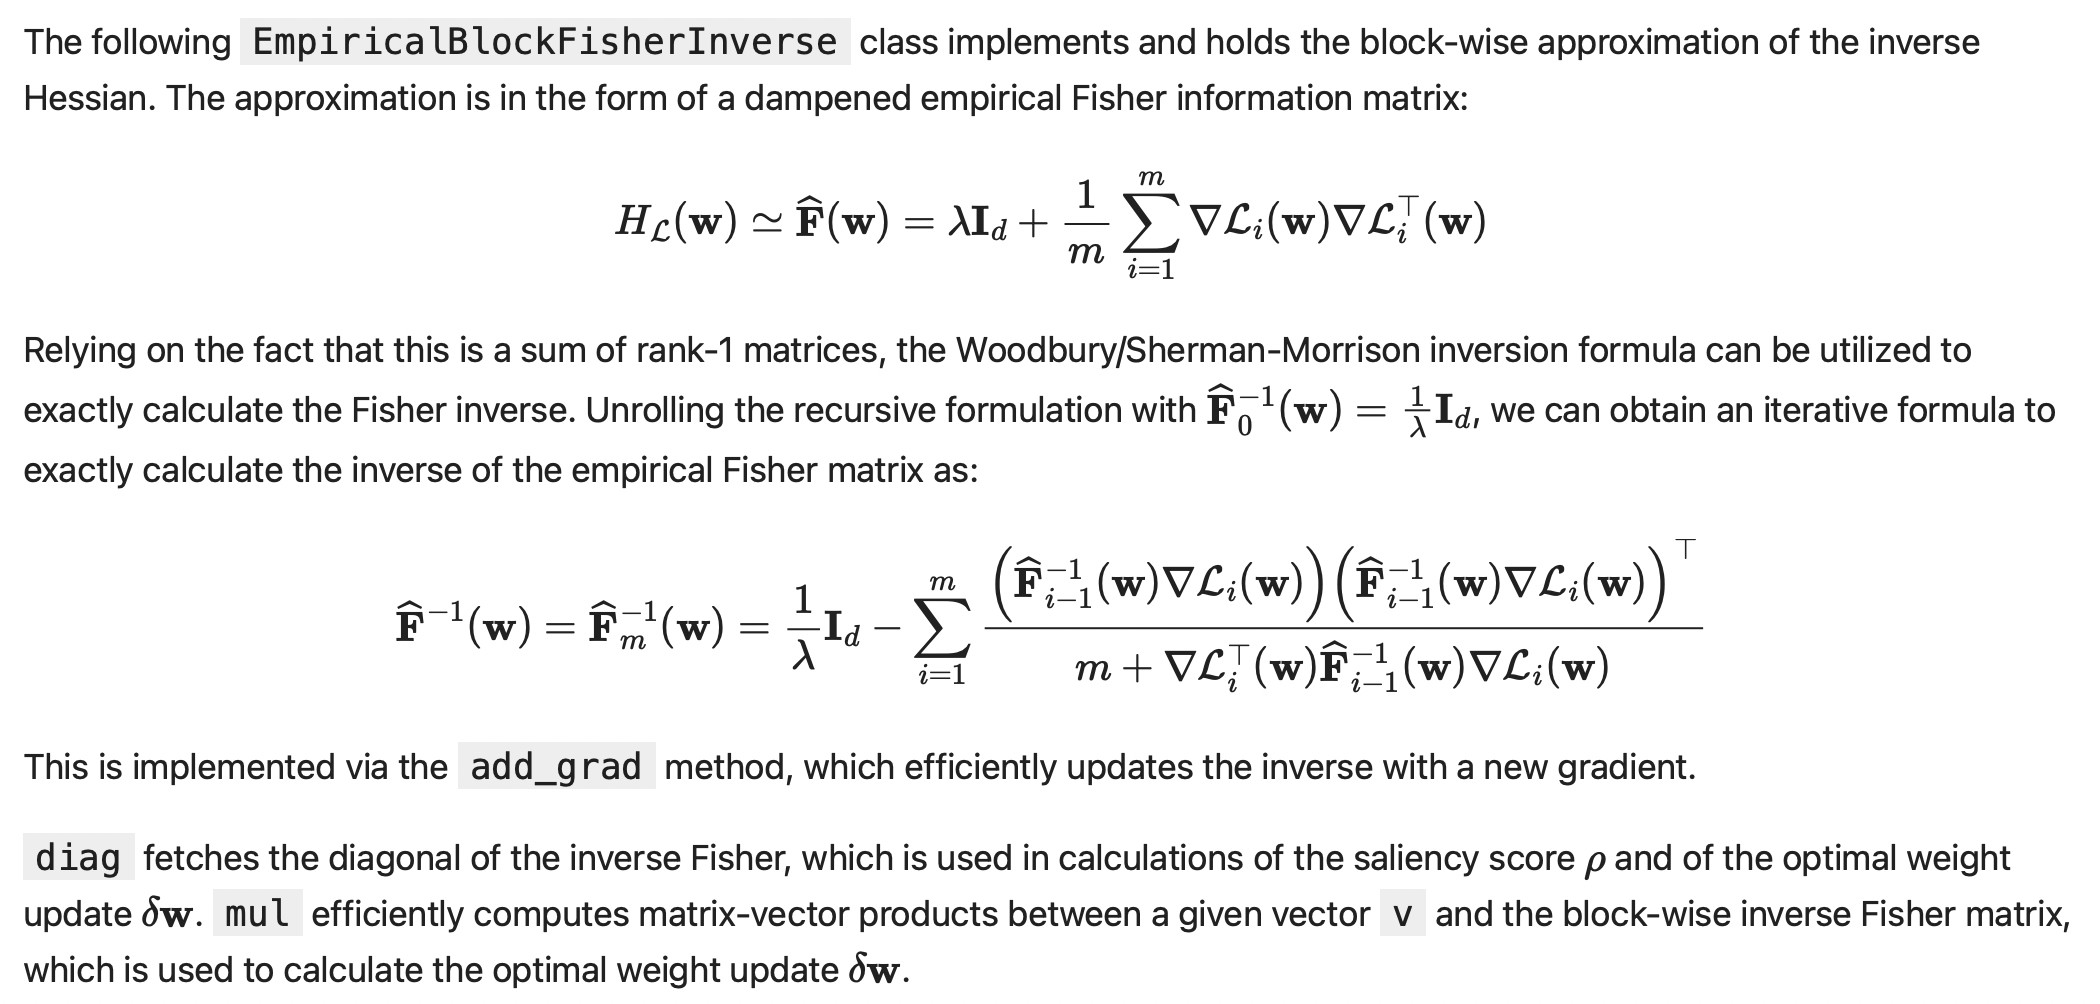

In [ ]:
class EmpiricalBlockFisherInverse:
    def __init__(
        self,
        num_grads: int,
        fisher_block_size: int,
        num_weights: int,
        damp: float,
        device: torch.device,
    ):
        self.m = num_grads
        self.B = fisher_block_size
        self.d = num_weights
        self.damp = damp
        self.dev = device

        self.num_blocks = math.ceil(self.d / self.B)
        self.F_inv = (
            (1.0 / self.damp * torch.eye(n=self.B, device=self.dev))
            .unsqueeze(0)
            .repeat(self.num_blocks, 1, 1)
        )  # takes O(d x B) memory on a device

    def add_grad(self, g: Tensor):
        """
        Updates empirical Fisher inverse with a new gradient
        :param g: a collected gradient
        """
        # if 'd / B' is not integer, pad with zeros for batch calculations
        if g.numel() < self.num_blocks * self.B:
            g = torch.cat(
                [g, torch.zeros(self.num_blocks * self.B - g.numel(), device=g.device)]
            )

        # prepare grad for batch calculations
        g = g.view(self.num_blocks, self.B)

        # batched F_inv x g: (batch, B, B) x (batch, B) -> (batch, B)
        Finv_g = torch.einsum("bij,bj->bi", self.F_inv, g)

        # scalar denominator for each batch: (batch)
        alpha = (self.m + torch.einsum("bi,bi->b", g, Finv_g)).sqrt().unsqueeze(1)
        Finv_g /= alpha

        # update F_inv with new outer product: (batch, B) x (batch, B) -> (batch, B, B)
        self.F_inv.baddbmm_(Finv_g.unsqueeze(2), Finv_g.unsqueeze(1), alpha=-1)

    def diag(self) -> Tensor:
        """
        :return: diagonal of the Fisher inverse matrix
        """
        return self.F_inv.diagonal(dim1=1, dim2=2).flatten()[: self.d]

    def mul(self, v: Tensor) -> Tensor:
        """
        Computes matrix-vector product of the Fisher inverse matrix and a vector
        :param v: a vector to compute matrix-vector product with
        :return: result of the matrix-vector multiplication
        """
        if v.numel() < self.num_blocks * self.B:
            v = torch.cat(
                [v, torch.zeros(self.num_blocks * self.B - v.numel(), device=v.device)]
            )
        return torch.bmm(
            self.F_inv, v.view(self.num_blocks, self.B).unsqueeze_(2)
        ).flatten()[: self.d]

Now, we define a dummy neural-network model:

In [ ]:
CUDA_LAUNCH_BLOCKING=1

In [ ]:
device = torch.device('cuda')
d = 1000                          # number of prunable weights
w = torch.rand(d, device=device)  # dummy weights
target_sparsity = 0.7             # [0, 1.] range

In [ ]:
w

tensor([8.9670e-01, 2.9823e-02, 8.3387e-01, 1.0248e-01, 4.7503e-01, 5.2197e-02,
        8.8387e-01, 4.0927e-01, 6.7259e-01, 4.6665e-02, 2.0240e-01, 5.1306e-01,
        2.1149e-01, 3.6138e-01, 6.2703e-02, 3.0051e-01, 5.4899e-01, 9.0967e-01,
        1.5027e-01, 9.3281e-01, 6.5033e-01, 9.2029e-01, 1.2743e-01, 8.1363e-01,
        6.3891e-01, 1.3596e-01, 9.3174e-01, 8.2263e-02, 6.8584e-01, 9.9592e-01,
        4.4538e-01, 2.1276e-01, 6.8206e-01, 2.1272e-01, 8.4007e-01, 2.2407e-01,
        1.4067e-01, 6.3490e-03, 5.7238e-01, 2.0211e-01, 2.1113e-01, 3.1492e-01,
        3.4502e-01, 2.1393e-02, 2.6550e-01, 5.3581e-01, 4.2598e-01, 4.2826e-01,
        1.7453e-01, 7.0062e-01, 3.5267e-01, 5.2138e-01, 9.3370e-01, 5.7654e-01,
        9.5639e-01, 1.2788e-01, 5.0699e-01, 2.7791e-01, 8.2459e-01, 7.3126e-01,
        1.0141e-01, 6.3263e-01, 8.0388e-01, 1.1839e-01, 4.1828e-01, 2.5403e-01,
        9.5083e-01, 3.8486e-01, 7.8354e-01, 5.3791e-01, 3.3196e-01, 1.5250e-01,
        1.7893e-01, 3.1976e-01, 6.3772e-

Now, we specify oBERT pruning hyper-parameters:

In [ ]:
m = 100           # number of gradients
B = 50            # block size
lambd = 1e-7      # dampening

# initialize Fisher inverse, occupies O(Bd) memory
# for example: d=85_000_000, B=50 -> 85_000_000 * 50 * 4 / 1024^3 = 16GB
fisher_inv = EmpiricalBlockFisherInverse(m, B, d, lambd, device)

Now, we collect m gradients used to approximate the Fisher inverse:

In [ ]:
for i in range(m):
    grad = torch.rand(d, device=device)  # a dummy gradient
    fisher_inv.add_grad(grad)
    print(f"Fisher inverse updated with {i+1} gradients", end="\r")
print('\n')

Fisher inverse updated with 100 gradients



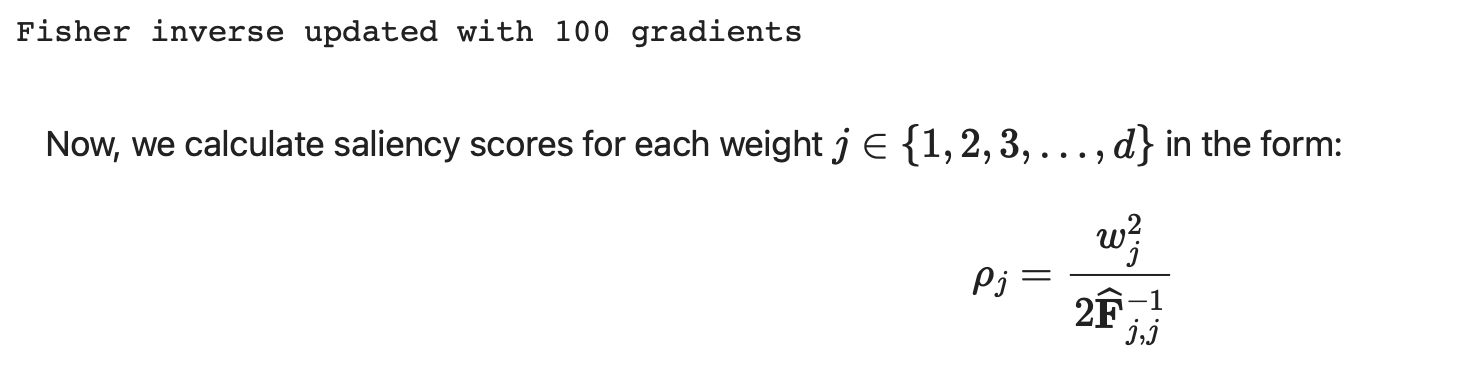

In [ ]:
scores = (w**2) / (2.0 * fisher_inv.diag())

Now, we prune target_sparsity * d weights:

In [ ]:
# find pruning threshold
kth_score = torch.kthvalue(scores, round(target_sparsity * d))[0]

# prune (i.e. set masks)
mask = scores > kth_score
print(f"Pruned model's sparsity = {1 - torch.sum(mask)/mask.numel()}")

Pruned model's sparsity = 0.699999988079071


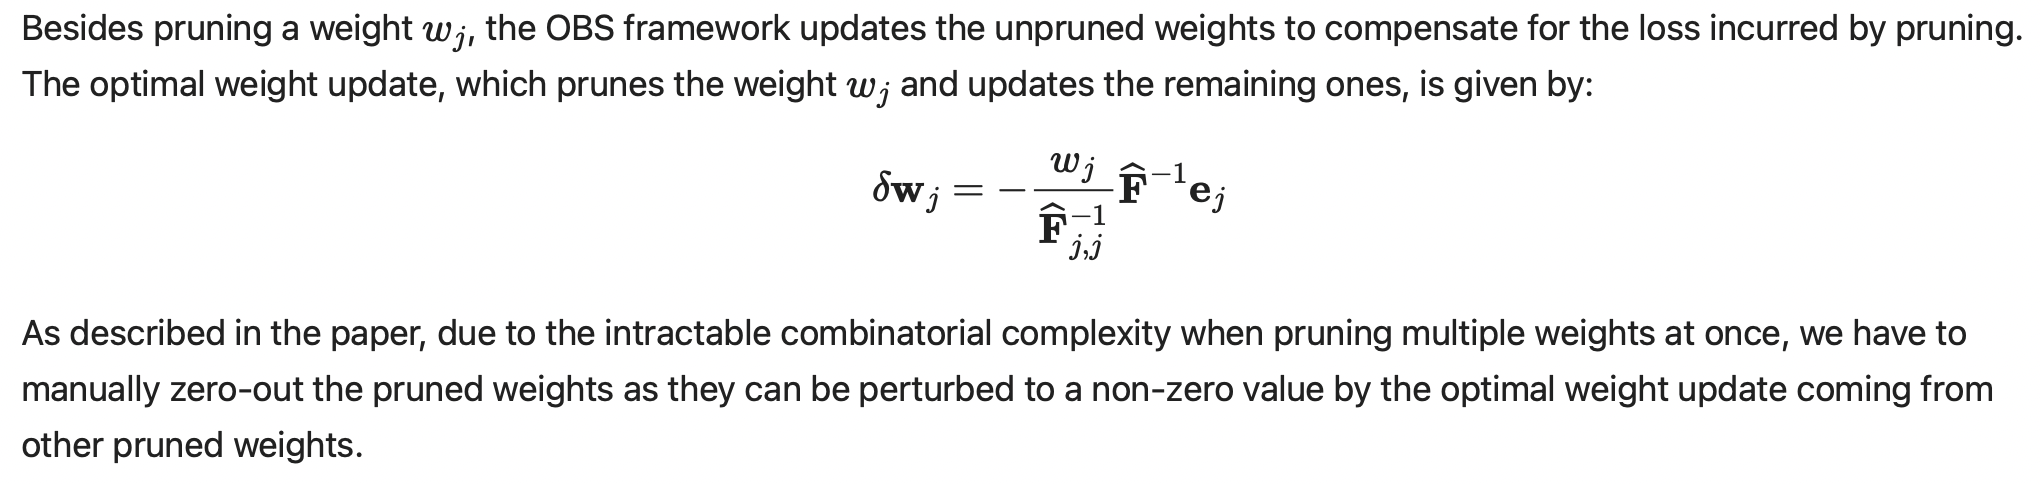

In [ ]:
w -= fisher_inv.mul(w * (mask == 0) / fisher_inv.diag())
w[mask == 0] = 0.0

The 4-block oBERT pruning follows the same procedure, except that it implements a slightly different scoring and the optimal weight update equations, which can be found in the paper and in the SparseML integration.

In [ ]:
w

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.9131, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9712, 0.0000,
        1.1168, 1.0820, 0.0000, 0.0000, 0.0000, 1.4058, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 1.0756, 0.0000, 0.0000, 0.0000, 0.0000, 1.0579, 0.0000,
        0.0000, 0.0000, 0.0000, 0.7861, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 1.3441, 0.0000, 0.0000, 1.1665, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 1.4029, 0.6277, 0.0000, 0.9626, 0.0000, 1.4863, 0.5835,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.4367, 0.0000, 0.0000, 1.3274,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0676, 0.0000, 0.0000,
        0.0000, 1.2860, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.1079, 0.9757,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9685, 0.0000,
        0.0000, 0.0000, 0.0000, 0.8553, 0.8884, 0.9103, 1.0362, 0.0000, 1.2233,
        0.0000, 0.0000, 0.0000, 0.7590, 